### Задание к домашней работе

Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет www.kaggle.com...iques/data (train.csv)

Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей

Построить случайный лес, вывести важность признаков

Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии

Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [2]:
import pandas as pd
import numpy as np
import scipy.stats # При работе со статистикой
import matplotlib.pyplot as plt  # Библиотека для визуализации результатов
import matplotlib.font_manager 
%matplotlib inline
import seaborn as sns

from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

In [3]:
data  =  pd.read_csv('train.csv')

In [4]:
data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [5]:
# разделяем на тренировочные и тестовые данные
data_train, data_test, y_train, y_test = train_test_split(data.drop(columns = 'SalePrice'),
                                                          data['SalePrice'],
                                                          test_size = 0.30,
                                                          random_state = 42)

In [6]:
#находим категориальные признаки

categorials = list(data.dtypes[data.dtypes == object].index)

categorials_nunique = data_train[categorials].nunique()

#закодируем пропущенные значения строкой, факт пропущенного значения тоже может нести в себе информацию
data[categorials] = data[categorials].fillna('nan')


In [7]:
# отфильтруем непрерывные признаки

integer  = [f for f in data if f not in (categorials + ['ID', 'SalePrice'])]

In [8]:
#создаем дамми-переменные для категорий

dummy_train = pd.get_dummies(data_train[categorials], columns = categorials)
dummy_test = pd.get_dummies(data_test[categorials], columns = categorials)

dummy_cols = list(set(dummy_train) & set (dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальные значения -999, что бы деревья могли их отличить(не обязательно теревья)

X_train = pd.concat([data_train[integer].fillna(-999), dummy_train], axis = 1)

X_test = pd.concat([data_test[integer].fillna(-999), dummy_test], axis = 1)

### Построим случайный лес

In [9]:
from sklearn.ensemble  import RandomForestRegressor
# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

In [10]:
print(f' Score on train data with models RandomForestRegressor {rf.score(X_train,y_train)}')
print(f' Score on test data with models RandomForestRegressor {rf.score(X_test,y_test)}')

 Score on train data with models RandomForestRegressor 0.959193461555807
 Score on test data with models RandomForestRegressor 0.8797319777205984


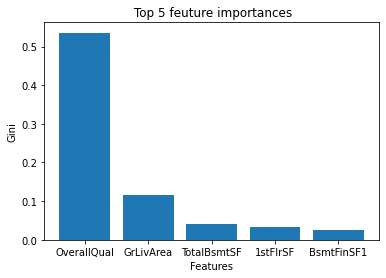

In [12]:
#  выявляем наиболее важные признаки и выводим на график. 
# Большое значение имеет признак Overall Qual, остальные почти равны нулю
imp = pd.Series(rf.feature_importances_)

imp.index  = pd.Series(X_train.columns)

plt.title(' Top 5 feuture importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head().index, imp.sort_values(ascending = False).head())
plt.show()

### Стэккинг

In [40]:
from sklearn.ensemble import StackingRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [41]:
# создаем стэккинг и обучаем его на наших данных
Regressor = StackingRegressor(
[
    ('LinearRegression',LinearRegression()),# Берем сначало обычную линейную регресисию
    ('KNeighborsRegressor',KNeighborsRegressor()),#  потом алгоритм на ближайших соседей
    ('DecisionTreeRegressor', DecisionTreeRegressor())  # потом регрессор на основе решающего дерева   
], RidgeCV(alphas = (0.1, 1.0, 10.0)) # Все 3 алгоритма дают нам ответ и  этот ответ с помощью линейной регресии обьединяем с L2 регуляризацией для того что бы сильно коллерированные данные нормально обьединились
)


С помощью крос валидации ...CV() проверяется качество.

In [42]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTreeRegressor',
                               DecisionTreeRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [43]:
print(f' Score on train data {Regressor.score(X_train,y_train)}')
print(f' Score on test data {Regressor.score(X_test,y_test)}')

for i in Regressor.named_estimators:
    print(f' Score on train data with models {i} {Regressor.named_estimators_[i].score(X_train,y_train)}')
    print(f' Score on test data with models {i} {Regressor.named_estimators_[i].score(X_test,y_test)}')

 Score on train data 0.9516118509905929
 Score on test data 0.8710272085420683
 Score on train data with models LinearRegression 0.922108540356243
 Score on test data with models LinearRegression 0.8533836050579298
 Score on train data with models KNeighborsRegressor 0.7419951520813983
 Score on test data with models KNeighborsRegressor 0.6775304068635524
 Score on train data with models DecisionTreeRegressor 1.0
 Score on test data with models DecisionTreeRegressor 0.7734722055815169
